In [ ]:
# install tensorflow and other modules
# NOTE: tensorflow probability 0.24.0 supports tensorflow 2.16.1
# NOTE: tf-keras: tensorflow>2.16 uses Keras3. To use Keras2, install tf-keras and import tf_keras instead of tf.keras
# REF: https://github.com/tensorflow/probability/releases
%pip install tensorflow[and-cuda]==2.16.1 tensorflow-probability==0.24.0 tf-keras

In [ ]:
# Check if TensorFlow is using GPU

# Check tf and tfp versions
import tensorflow as tf
import tensorflow_probability as tfp
print("TensorFlow version: ", tf.__version__)
print("TensorFlow Probability version: ", tfp.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.Tensor(
[[-1.7612407   1.0427709 ]
 [-0.9233536   0.54682285]
 [-1.5958358   0.34744185]
 ...
 [ 2.733147    1.8477143 ]
 [-1.9138541   0.2210698 ]
 [ 2.2073321   0.18851303]], shape=(10000, 2), dtype=float32) (10000, 2)
target_function: input:  [[-3.676312  -3.7666695]
 [-3.5992358 -3.7666695]
 [-3.5221596 -3.7666695]
 ...
 [ 3.800076   4.4277034]
 [ 3.8771524  4.4277034]
 [ 3.954229   4.4277034]]
target_function: input:  Tensor("monte_carlo_variational_loss/chain_of_invert_masked_autoregressive_flow_of_invert_masked_autoregressive_flowSampleNormal_CONSTRUCTED_AT_top_level/sample_and_log_prob/chain_of_invert_masked_autoregressive_flow_of_invert_masked_autoregressive_flow/forward/masked_autoregressive_flow/inverse_1/chain_of_shift_of_scale/inverse/scale/inverse/mul:0", shape=(256, 2), dtype=float32)
target_function: input:  Tensor("monte_carlo_variational_loss/chain_of_invert_masked_autoregressive_flow_of_invert_masked_autoregressive_flowSampleNormal_CONSTRUCTED_AT_top_level/sample_

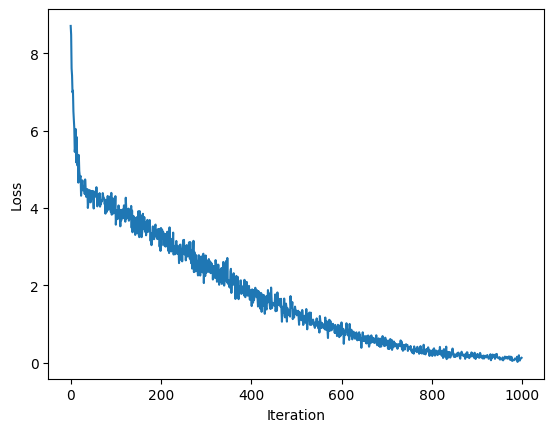

target_function: input:  [[-2.2344534 -1.5311161]
 [-2.1309674 -1.5311161]
 [-2.0274816 -1.5311161]
 ...
 [ 7.803686   6.6922026]
 [ 7.907172   6.6922026]
 [ 8.010658   6.6922026]]
(10000,) (10000,) (10000,)


/tmp/ipykernel_107651/624599126.py:100: UserWarning: The following kwargs were not used by contour: 'label'
  ax = plt.contour(X.reshape(shape), Y.reshape(shape), Z.reshape(shape), label="True distribution")
/tmp/ipykernel_107651/624599126.py:101: UserWarning: The following kwargs were not used by contour: 'label'
  ax = plt.contour(X_before_train.reshape(shape), Y_before_train.reshape(shape), Z_before_train.reshape(shape), label="Before training", linestyles=":", cmap="viridis")
/tmp/ipykernel_107651/624599126.py:102: UserWarning: The following kwargs were not used by contour: 'label'
  ax = plt.contour(X.reshape(shape), Y.reshape(shape), Z_trained.reshape(shape), label="Trained distribution", linestyles="--", cmap="viridis")


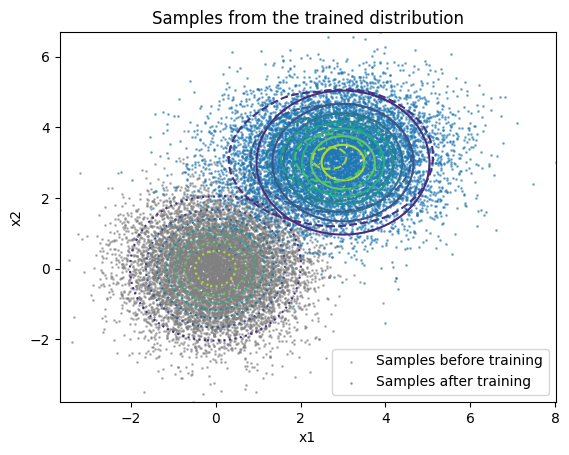

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

# # Suppose we have a complex target function that uses NumPy
# def target_function_np(x):
#     # x: NumPy array of shape [batch_size, 2]
#     # Here for demonstration, we define a simple function for standard normal distribution's log pdf
#     return -0.5 * np.sum((x-np.array([3,3]))**2, axis=1) - np.log(2 * np.pi)
#     # Here for another demonstration, more complex function: multivariate normal distribution
#     # mean = np.array([0.5, 0.5])
#     # cov = np.array([[1.0, 0.8], [0.8, 1.0]])
#     # return -0.5 * np.sum((x - mean) @ np.linalg.inv(cov) * (x - mean), axis=1) - np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(cov))

# # Convert the function to a TensorFlow function for Graph execution
# def target_function(x):
#     # x: TensorFlow tensor of shape [batch_size, 2]
#     # Compute the log probability using the NumPy-based function
#     log_prob = tf.py_function(
#         func=target_function_np, 
#         inp=[x], 
#         Tout=tf.float32)
#     return log_prob

# Define the target function using TensorFlow operations
def target_function(x):
    print("target_function: input: ",x)
    # x: TensorFlow tensor of shape [batch_size, 2]
    mean = tf.constant([3.0, 3.0], dtype=tf.float32)
    log_prob = -0.5 * tf.reduce_sum((x - mean) ** 2, axis=1) - np.log(2 * np.pi)
    return log_prob

# Define base distribution
base_distribution = tfd.Sample(tfd.Normal(loc=0., scale=1), sample_shape=[2])

# Define the normalizing flow using IAF
iaf_bijector = [
    tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, 
            hidden_units=[256,256], 
            activation="relu"
        )
    ))
    for _ in range(2)
]

iaf_surrogate_posterior = tfd.TransformedDistribution(
    distribution=base_distribution,
    bijector=tfb.Chain(iaf_bijector),
    validate_args=False
)

# check the shape of sample from the surrogate posterior
iaf_samples_before_train = iaf_surrogate_posterior.sample(10000)
print(iaf_samples_before_train,iaf_samples_before_train.shape)
# store log_prob of the samples from the surrogate posterior before training
x = np.linspace(np.min(iaf_samples_before_train, axis=0), np.max(iaf_samples_before_train, axis=0), 100)
X, Y = np.meshgrid(x[:, 0], x[:, 1])
shape = X.shape
X_before_train = X.flatten()
Y_before_train = Y.flatten()
Z = np.exp(target_function(np.stack([X_before_train, Y_before_train], axis=-1)))
Z_before_train = np.exp(iaf_surrogate_posterior.log_prob(np.stack([X_before_train, Y_before_train], axis=-1)))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
iaf_loss = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=target_function,
    surrogate_posterior=iaf_surrogate_posterior,
    optimizer=optimizer,
    num_steps=1000,
    sample_size=256,
    # jit_compile=True
)

iaf_samples = iaf_surrogate_posterior.sample(10000)

iaf_final_elbo = tf.reduce_mean(
    target_function(iaf_samples)
    - iaf_surrogate_posterior.log_prob(iaf_samples))
print("IAF final ELBO: ", iaf_final_elbo)

plt.plot(iaf_loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

x = np.linspace(np.min(iaf_samples, axis=0), np.max(iaf_samples, axis=0), 100)
X, Y = np.meshgrid(x[:, 0], x[:, 1])
shape = X.shape
X = X.flatten()
Y = Y.flatten()
Z = np.exp(target_function(np.stack([X, Y], axis=-1)))
Z_trained = np.exp(iaf_surrogate_posterior.log_prob(np.stack([X, Y], axis=-1)))
print(X.shape, Y.shape, Z.shape)
ax = plt.contour(X.reshape(shape), Y.reshape(shape), Z.reshape(shape), label="True distribution")
ax = plt.contour(X_before_train.reshape(shape), Y_before_train.reshape(shape), Z_before_train.reshape(shape), label="Before training", linestyles=":", cmap="viridis")
ax = plt.contour(X.reshape(shape), Y.reshape(shape), Z_trained.reshape(shape), label="Trained distribution", linestyles="--", cmap="viridis")
plt.scatter(iaf_samples_before_train[:, 0], iaf_samples_before_train[:, 1], s=1, alpha=0.5, c="gray", label="Samples before training")
plt.scatter(iaf_samples[:, 0], iaf_samples[:, 1], s=1, alpha=0.5, label="Samples after training")

plt.title("Samples from the trained distribution")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sashimi_c
import tensorflow.experimental.numpy as tnp
import numpy as np

sashimi_c.set_numpy("tensorflow")
out_tf = sashimi_c.subhalo_properties().Na_calc(np.array([1.,1.,1.,]),np.array([1.,2.,3.]),1.e12)
print(out_tf)

out_tf_2 = sashimi_c.subhalo_properties()._Na_calc(np.array([1.,1.,1.,]),np.array([1.,2.,3.]),1.e12)
print(out_tf_2)

sashimi_c.set_numpy("numpy")
out_np = sashimi_c.subhalo_properties().Na_calc(np.array([1.,1.,1.,]),np.array([1.,2.,3.]),1.e12)
print(out_np)

2024-11-19 15:36:06.168212: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 15:36:06.817937: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using numpy
Using tensorflow.experimental.numpy


2024-11-19 15:36:07.601344: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 15:36:07.636887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 15:36:07.637126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

tf.Tensor(
[[2.28236831e+09 2.28236831e+09 2.28236831e+09]
 [1.83158829e+09 1.83158829e+09 1.83158829e+09]
 [1.30178081e+09 1.30178081e+09 1.30178081e+09]], shape=(3, 3), dtype=float64)
tf.Tensor([2.28236831e+09 1.83158829e+09 1.30178081e+09], shape=(3,), dtype=float64)
Using numpy
[[2.28228161e+09 2.28228161e+09 2.28228161e+09]
 [1.83159957e+09 1.83159957e+09 1.83159957e+09]
 [1.30166029e+09 1.30166029e+09 1.30166029e+09]]


In [ ]:
sashimi_c.set_numpy("tensorflow")
out_tf = sashimi_c.subhalo_properties().Na_calc(np.array([1.,2.,3.,]),np.array([1.,2.]),1.e12)
print(out_tf)

out_tf_general = sashimi_c.subhalo_properties().Na_calc_general(np.array([1.,2.,3.,]),np.array([1.,2.]),1.e12)

In [4]:
import sashimi_c
import tensorflow.experimental.numpy as tnp
import numpy as np
import tensorflow as tf

sashimi_c.set_numpy("tensorflow")

ma = tf.constant([1,2], dtype=tf.float64)
zacc = tf.Variable([1.0,2.0,3.0], dtype=tf.float64)
Mhost = tf.constant(1.e12, dtype=tf.float64)

with tf.GradientTape() as tape:
    Na = sashimi_c.subhalo_properties().Na_calc(ma, zacc, Mhost)

grads = tape.gradient(Na, zacc)
print("勾配(zacc):", grads)


ma = tf.Variable([1,2], dtype=tf.float64)
zacc = tf.constant([1.0,2.0,3.0], dtype=tf.float64)
Mhost = tf.constant(1.e12, dtype=tf.float64)

with tf.GradientTape() as tape:
    Na = sashimi_c.subhalo_properties().Na_calc(ma, zacc, Mhost)

grads = tape.gradient(Na, ma)
print("勾配(ma):", grads)

Using tensorflow.experimental.numpy
勾配(zacc): tf.Tensor([-6.15228870e+08 -7.93929147e+08 -7.66892943e+08], shape=(3,), dtype=float64)
勾配(ma): tf.Tensor([-5.02481351e+09 -1.31937740e+09], shape=(2,), dtype=float64)


In [2]:
import numpy as np
import tensorflow.experimental.numpy as tnp

np.__name__, tnp.__name__


('numpy', 'tensorflow.experimental.numpy')

In [3]:
import sashimi_c
import tensorflow.experimental.numpy as tnp
import numpy as np
import tensorflow as tf

sashimi_c.set_numpy("tensorflow")

ma = tf.constant([1.,2.,3.], dtype=tf.float64)
zacc = tf.Variable([1.0,1.5,2.0], dtype=tf.float64)
M200 = tf.constant([1.e11,1.e11,1.e11], dtype=tf.float64)
Mhost = tf.constant([1.e12,1.e12,1.e12], dtype=tf.float64)


with tf.GradientTape() as tape:
    Na = sashimi_c.subhalo_properties().Na_calc_general(ma, zacc, M200, Mhost)

grads = tape.gradient(Na, zacc)
print("勾配(zacc):", grads)


ma = tf.Variable([1,2], dtype=tf.float64)
zacc = tf.constant([1.0,2], dtype=tf.float64)
M200 = tf.constant([1.e11,1e11], dtype=tf.float64)
Mhost = tf.constant([1.e12,1e12], dtype=tf.float64)

with tf.GradientTape() as tape:
    Na = sashimi_c.subhalo_properties().Na_calc_general(ma, zacc, M200, Mhost)

grads = tape.gradient(Na, ma)
print("勾配(ma):", grads)

Using tensorflow.experimental.numpy
勾配(zacc): tf.Tensor([-1.32071488e+09 -6.36986759e+08 -3.54651568e+08], shape=(3,), dtype=float64)
勾配(ma): tf.Tensor([-3.14462928e+09 -5.05370583e+08], shape=(2,), dtype=float64)


Using numpy


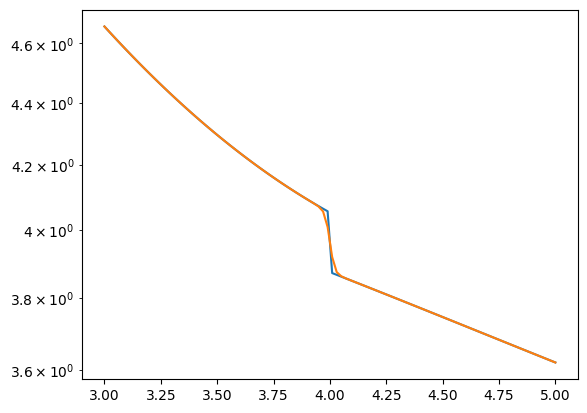

In [11]:
import matplotlib.pyplot as plt
import numpy as np

hm = sashimi_c.halo_model()

z = np.linspace(3, 5, 100)
plt.plot(z,hm.conc200(1e10,z),label="conc200")
plt.plot(z,hm.conc200_smooth(1e10,z),label="conc200_smooth")
plt.yscale("log")
plt.show()


Using tensorflow.experimental.numpy
target_function: input: Tensor("monte_carlo_variational_loss/chain_of_chain_of_invert_split_of_jointmap_of_soft_clip_and_softplus_of_split_of_invert_masked_autoregressive_flow_of_invert_masked_autoregressive_flowSampleNormal_CONSTRUCTED_AT_top_level/sample_and_log_prob/chain_of_chain_of_invert_split_of_jointmap_of_soft_clip_and_softplus_of_split_of_invert_masked_autoregressive_flow_of_invert_masked_autoregressive_flow/forward/chain_of_invert_split_of_jointmap_of_soft_clip_and_softplus_of_split/forward/split/inverse/concat:0", shape=(1, 2), dtype=float32)
target_function: Na: Tensor("monte_carlo_variational_loss/expectation/mul_135:0", shape=(1,), dtype=float64)
target_function: input: Tensor("monte_carlo_variational_loss/chain_of_chain_of_invert_split_of_jointmap_of_soft_clip_and_softplus_of_split_of_invert_masked_autoregressive_flow_of_invert_masked_autoregressive_flowSampleNormal_CONSTRUCTED_AT_top_level/sample_and_log_prob/chain_of_chain_of_invert

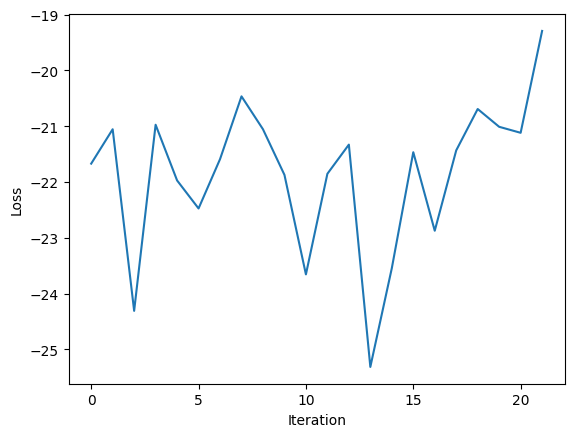

target_function: input: [[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
target_function: Na: tf.Tensor([nan nan nan ... nan nan nan], shape=(10000,), dtype=float64)
(X,Y,Z): (10000,) (10000,) (10000,)


/tmp/ipykernel_180600/4159356941.py:141: UserWarning: The following kwargs were not used by contour: 'label'
  ax = plt.contour(X.reshape(shape), Y.reshape(shape), Z.reshape(shape), label="True distribution")
/tmp/ipykernel_180600/4159356941.py:142: UserWarning: The following kwargs were not used by contour: 'label'
  ax = plt.contour(X_before_train.reshape(shape), Y_before_train.reshape(shape), Z_before_train.reshape(shape), label="Before training", linestyles=":", cmap="viridis")
/tmp/ipykernel_180600/4159356941.py:143: UserWarning: The following kwargs were not used by contour: 'label'
  ax = plt.contour(X.reshape(shape), Y.reshape(shape), Z_trained.reshape(shape), label="Trained distribution", linestyles="--", cmap="viridis")


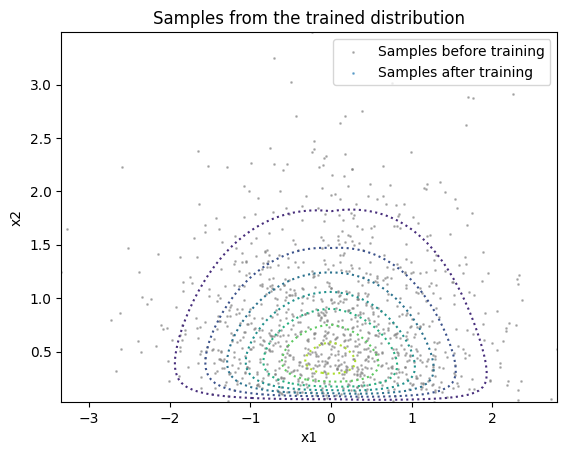

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()
import sashimi_c

sashimi_c.set_numpy("tensorflow")

tfb = tfp.bijectors
tfd = tfp.distributions

# # Suppose we have a complex target function that uses NumPy
# def target_function_np(x):
#     # x: NumPy array of shape [batch_size, 2]
#     # Here for demonstration, we define a simple function for standard normal distribution's log pdf
#     return -0.5 * np.sum((x-np.array([3,3]))**2, axis=1) - np.log(2 * np.pi)
#     # Here for another demonstration, more complex function: multivariate normal distribution
#     # mean = np.array([0.5, 0.5])
#     # cov = np.array([[1.0, 0.8], [0.8, 1.0]])
#     # return -0.5 * np.sum((x - mean) @ np.linalg.inv(cov) * (x - mean), axis=1) - np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(cov))

# # Convert the function to a TensorFlow function for Graph execution
# def target_function(x):
#     # x: TensorFlow tensor of shape [batch_size, 2]
#     # Compute the log probability using the NumPy-based function
#     log_prob = tf.py_function(
#         func=target_function_np, 
#         inp=[x], 
#         Tout=tf.float32)
#     return log_prob

sh = sashimi_c.subhalo_properties()

# Define the target function using TensorFlow operations
def target_function(x):
    print("target_function: input:",x)
    # x: TensorFlow tensor of shape [batch_size, 2]
    # Call sh._Na_calc(ma,zacc,Mhost=1e12)
    x = tnp.array(tf.cast(x, tf.float64))
    ln_ma = x[:,0]
    ln_z = x[:,1]
    ma = tnp.exp(ln_ma)
    zacc = tnp.exp(ln_z)
    Mhost = 1.e12
    Na = sh._Na_calc(ma,zacc,Mhost)
    # cast to float32
    print("target_function: Na:",Na)
    # NOTE: Na * d(ln m) * d(ln(1+z))
    #       = Na * z / (1+z) * d(ln m) * d(ln z)
    #       = Na / (1+z) * d(ln m) * dz)
    prob = Na / (1+zacc)  
    # replace NaN with -inf
    log_prob = tf.cast(tnp.log(prob), tf.float32)
    return tnp.where(tnp.isnan(log_prob), -np.inf, log_prob)

# Define base distribution
base_distribution = tfd.Sample(tfd.Normal(loc=0., scale=1), sample_shape=[2])

# Define the normalizing flow using IAF
iaf_bijectors = [
    tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, 
            hidden_units=[256,256], 
            activation="relu"
        )
    ))
    for _ in range(2)
]

# NOTE: iaf_surrogate_posterior.sample must be constrained to [x,y] where
# y > 0.0
# To constrain, we define a constraint bijector.
# Constraint bijector: [x,y] -> [x,softplus(y)]

# Define the constraint bijector
constraint_bijector = tfb.Chain([
    tfb.Invert(tfb.Split(2, axis=-1)),
    tfb.JointMap([
        tfb.SoftClip(low=-6,high=10), # For ln_ma
        tfb.Softplus()  # For ln_zacc
        ]),
    tfb.Split(2, axis=-1)
])


iaf_surrogate_posterior = tfd.TransformedDistribution(
    distribution=base_distribution,
    bijector=tfb.Chain([
        constraint_bijector, *iaf_bijectors]),
    validate_args=False
)

# check the shape of sample from the surrogate posterior
iaf_samples_before_train = iaf_surrogate_posterior.sample(1000)
# print("iad_samples_before_train",iaf_samples_before_train,iaf_samples_before_train.shape)
# store log_prob of the samples from the surrogate posterior before training
x = np.linspace(np.min(iaf_samples_before_train, axis=0), np.max(iaf_samples_before_train, axis=0), 100)
X, Y = np.meshgrid(x[:, 0], x[:, 1])
shape = X.shape
X_before_train = X.flatten()
Y_before_train = Y.flatten()
XY_before_train = np.stack([X_before_train, Y_before_train], axis=-1)
Z_before_train = np.exp(iaf_surrogate_posterior.log_prob(XY_before_train))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
iaf_loss = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=target_function,
    surrogate_posterior=iaf_surrogate_posterior,
    optimizer=optimizer,
    num_steps=100,
    sample_size=1,
    # jit_compile=True
)

iaf_samples = iaf_surrogate_posterior.sample(1000)
# print("iaf_samples",iaf_samples)

iaf_final_elbo = tf.reduce_mean(
    target_function(iaf_samples)
    - iaf_surrogate_posterior.log_prob(iaf_samples))
print("IAF final ELBO: ", iaf_final_elbo)

print("loss:", iaf_loss)
plt.plot(iaf_loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

x = np.linspace(np.min(iaf_samples, axis=0), np.max(iaf_samples, axis=0), 100).astype(np.float64)
X, Y = np.meshgrid(x[:, 0], x[:, 1])
shape = X.shape
X = X.flatten()
Y = Y.flatten()
XY = np.stack([X, Y], axis=-1)
Z = np.exp(target_function(XY))
Z_trained = np.exp(iaf_surrogate_posterior.log_prob(XY))
print("(X,Y,Z):",X.shape, Y.shape, Z.shape)
ax = plt.contour(X.reshape(shape), Y.reshape(shape), Z.reshape(shape), label="True distribution")
ax = plt.contour(X_before_train.reshape(shape), Y_before_train.reshape(shape), Z_before_train.reshape(shape), label="Before training", linestyles=":", cmap="viridis")
ax = plt.contour(X.reshape(shape), Y.reshape(shape), Z_trained.reshape(shape), label="Trained distribution", linestyles="--", cmap="viridis")
plt.scatter(iaf_samples_before_train[:, 0], iaf_samples_before_train[:, 1], s=1, alpha=0.5, c="gray", label="Samples before training")
plt.scatter(iaf_samples[:, 0], iaf_samples[:, 1], s=1, alpha=0.5, label="Samples after training")

plt.title("Samples from the trained distribution")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

target_function: input: [[-10.        -10.       ]
 [ -9.7979798 -10.       ]
 [ -9.5959596 -10.       ]
 ...
 [  9.5959596  10.       ]
 [  9.7979798  10.       ]
 [ 10.         10.       ]]
target_function: Na: tf.Tensor(
[2.64313197e+13 2.18385946e+13 1.80450743e+13 ...            nan
            nan            nan], shape=(10000,), dtype=float64)


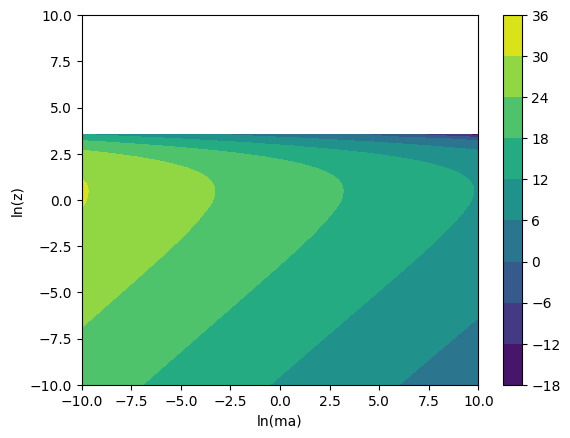

In [46]:
# contour plot for the target function
x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)
X, Y = np.meshgrid(x, y)
shape = X.shape
X = X.flatten()
Y = Y.flatten()
XY = np.stack([X, Y], axis=-1)
Z = target_function(XY)
ax = plt.contourf(X.reshape(shape), Y.reshape(shape), Z.reshape(shape))
plt.xlabel("ln(ma)")
plt.ylabel("ln(z)")
plt.colorbar(ax)


(100, 101) (100, 101)
(100, 101)


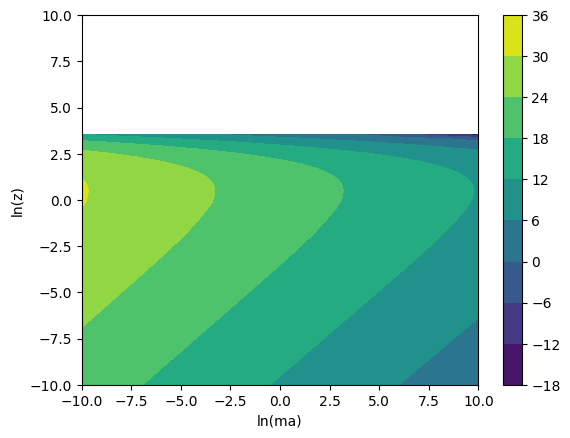

In [55]:
# contour plot for the target function
x = np.linspace(-10,10,101)  # ln_ma
y = np.linspace(-10,10,100)  # ln_z
X, Y = np.meshgrid(x, y)
print(X.shape,Y.shape)
Z = sh.Na_calc(np.exp(x),np.exp(y),1.e12)
Z = Z * (np.exp(Y))/(1+np.exp(Y))
Z = np.log(Z)
print(Z.shape)
plt.contourf(X, Y, Z)
plt.xlabel("ln(ma)")
plt.ylabel("ln(z)")
plt.colorbar()


In [61]:
import sashimi_c
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sashimi_c.set_numpy("numpy")
sh = sashimi_c.subhalo_properties()
# return: ma200, z_acc, rs_acc, rhos_acc, m_z0, rs_z0, rhos_z0, ct_z0, weight, survive
ret = sh.subhalo_properties_calc(1e12,N_herm=128)
ret_df = pd.DataFrame(np.array(ret).T, columns=["ma200", "z_acc", "rs_acc", "rhos_acc", "m_z0", "rs_z0", "rhos_z0", "ct_z0", "weight", "survive"])

Using numpy


In [14]:
%pip install pandas

  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.6 MB/s eta 0:00:00 0:00:01
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Note: you may need to restart the kernel to use updated packages.


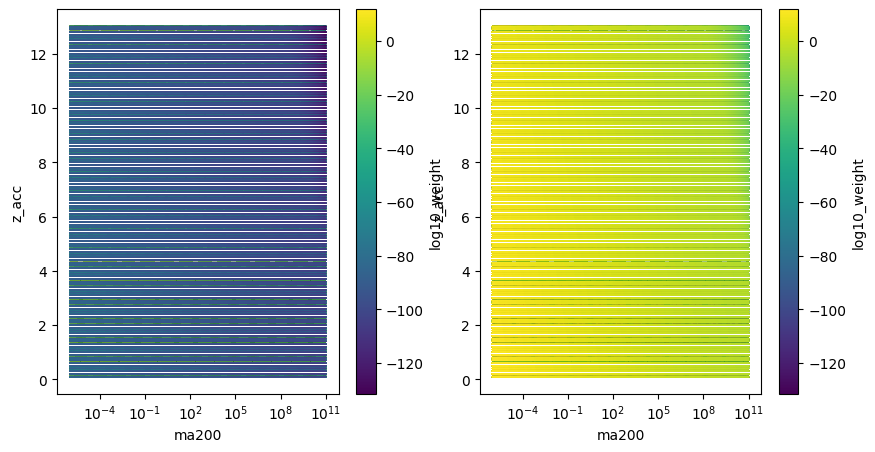

In [59]:
ret_df["log10_weight"] = ret_df["weight"].apply(np.log10)
x = "ma200"
y = "z_acc"
fig,axes = plt.subplots(1,2,figsize=(10,5))
ret_df.plot.scatter(x,y,c="log10_weight",ax=axes[0],s=1,linewidth=0)
ret_df.sort_values("log10_weight").plot.scatter(x,y,c="log10_weight",ax=axes[1],s=1,linewidth=0)
for ax in axes:
    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.set_xlabel(x)
    ax.set_ylabel(y)
plt.show()

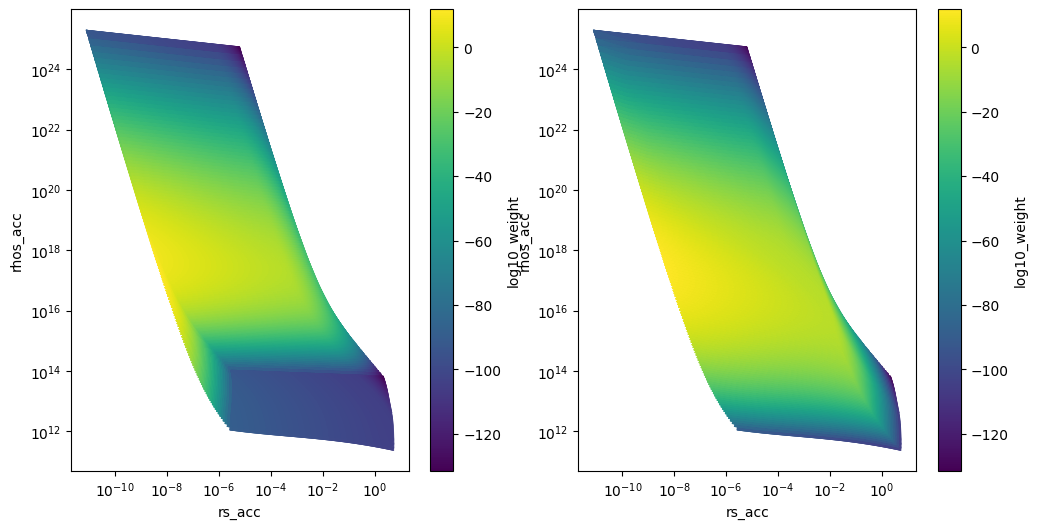

In [60]:
import numpy as np
x = "rs_acc"
y = "rhos_acc"
fig,axes = plt.subplots(1,2,figsize=(12,6))
ret_df.plot.scatter(x,y,c="log10_weight",s=1,linewidth=0,ax=axes[0])
ret_df.sort_values("log10_weight").plot.scatter(x,y,c="log10_weight",s=1,linewidth=0,ax=axes[1])
for ax in axes:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(x)
    ax.set_ylabel(y)
plt.show()

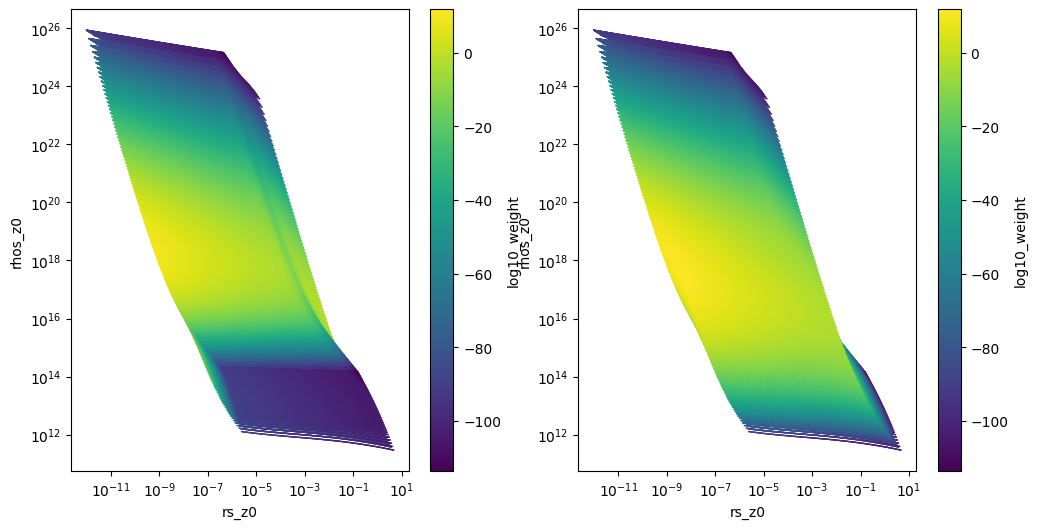

In [38]:
import numpy as np
x = "rs_z0"
y = "rhos_z0"
fig,axes = plt.subplots(1,2,figsize=(12,6))
ret_df.plot.scatter(x,y,c="log10_weight",s=1,linewidth=0,ax=axes[0])
ret_df.sort_values("log10_weight").plot.scatter(x,y,c="log10_weight",s=1,linewidth=0,ax=axes[1])
for ax in axes:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(x)
    ax.set_ylabel(y)
plt.show()

In [ ]:
# contour plot for the target function
x = np.linspace(-10,10,101)  # ln_ma
y = np.linspace(-10,10,100)  # ln_z
X, Y = np.meshgrid(x, y)
print(X.shape,Y.shape)
Z = sh.Na_calc(np.exp(x),np.exp(y),1.e12)
Z = Z * (np.exp(Y))/(1+np.exp(Y))
Z = np.log(Z)
print(Z.shape)
plt.contourf(X, Y, Z)
plt.xlabel("ln(ma)")
plt.ylabel("ln(z)")
plt.colorbar()
